### Compaison du modele avec et sans energy stare score
Au vue de nos metriques nous deduisons que l'impact de l'energy stare score pour notre modéle est négligeable au vue des coûts nécéssaire au calcul de ce score.


## Feature importance et interprétabilité du meilleur modéle
Vue que le deadline est proche nous ne pouvons pas nous lancer pour le feature importance du meilleur modéle.Toute fois notons que dans le notebook_06 à la fin nous avons procéder a une analyse des feature importance.le meilleur modéle dans ce notebook est similaire au meilleur modéle aprés experimentation Mlflow.

In [3]:
import sys
from pathlib import Path

# Racine projet
PROJECT_ROOT = Path("../").resolve()  # remonte d’un niveau depuis notebooks/
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

# Vérifier
print(sys.path)


['C:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\src', 'C:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\src', 'C:\\Users\\HP\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\HP\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\HP\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\HP\\AppData\\Local\\Programs\\Python\\Python312', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env', '', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env\\Lib\\site-packages', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env\\Lib\\site-packages\\win32', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\HP\\Desktop\\temp\\TODO\\SEMESTRE_1\\ML1\\ML-prediction-CO2\\env\\Lib\\site-packages\\Pythonwin']


In [4]:
from models.transformer import GroupMedianImputer, GroupModeImputer


    feature  coefficient  abs_coefficient
16  feat_16     1.492018         1.492018
58  feat_58     1.212173         1.212173
24  feat_24    -1.190434         1.190434
22  feat_22     1.112782         1.112782
12  feat_12    -1.032512         1.032512
59  feat_59     1.030673         1.030673
28  feat_28    -0.947757         0.947757
13  feat_13     0.934366         0.934366
26  feat_26     0.916663         0.916663
7    feat_7     0.883005         0.883005
41  feat_41    -0.494413         0.494413
39  feat_39    -0.381988         0.381988
33  feat_33    -0.344182         0.344182
29  feat_29    -0.340819         0.340819
32  feat_32     0.309310         0.309310


C:\Users\HP\AppData\Local\Temp\ipykernel_15612\4056497105.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


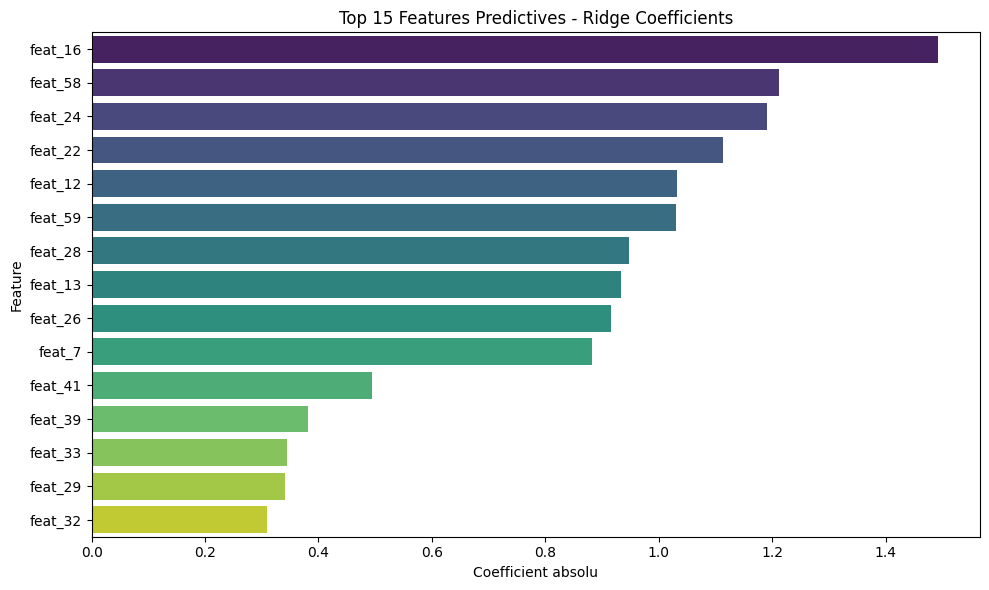


Importance agrégée par variable mère :
base_feature
feat    12.623092
Name: abs_coefficient, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_15612\4056497105.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features["base_feature"] = top_features["feature"].str.replace(r"^(num|cat|bin)__", "", regex=True).str.split("_").str[0]


In [5]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chemin du modèle sauvegardé
model_path = "../best_model/seattle_energy_2016_ml/best_model_ridge.joblib"

# Charger le pipeline
pipeline = joblib.load(model_path)

# Extraire le Ridge
model = pipeline.named_steps["model"]

# Essayer de récupérer les noms des features
try:
    preprocessor = pipeline.named_steps["preprocessor"]
    # Si X_train.columns disponible, fournir
    feature_names = preprocessor.get_feature_names_out()  
except Exception:
    feature_names = None

# Coefficients
coef = model.coef_

# DataFrame feature importance
if feature_names is not None and len(feature_names) == len(coef):
    importance = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coef,
        "abs_coefficient": np.abs(coef)
    }).sort_values("abs_coefficient", ascending=False)
else:
    # Si pas de noms de features, juste un ranking brut
    importance = pd.DataFrame({
        "feature": [f"feat_{i}" for i in range(len(coef))],
        "coefficient": coef,
        "abs_coefficient": np.abs(coef)
    }).sort_values("abs_coefficient", ascending=False)

# Top 15 features
top_features = importance.head(15)
print(top_features)

# --- Graphique ---
plt.figure(figsize=(10,6))
sns.barplot(
    x="abs_coefficient", 
    y="feature", 
    data=top_features, 
    palette="viridis"
)
plt.title("Top 15 Features Predictives - Ridge Coefficients")
plt.xlabel("Coefficient absolu")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optionnel : importance par variable mère (utile si OHE)
top_features["base_feature"] = top_features["feature"].str.replace(r"^(num|cat|bin)__", "", regex=True).str.split("_").str[0]

agg_importance = top_features.groupby("base_feature")["abs_coefficient"].sum().sort_values(ascending=False)
print("\nImportance agrégée par variable mère :")
print(agg_importance)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = importance.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features,
    x="abs_coefficient",
    y="feature",
    hue="feature",       # FIX seaborn
    dodge=False,
    legend=False,
)
plt.title("Top 15 composantes prédictives – Ridge")
plt.xlabel("Coefficient absolu")
plt.ylabel("Composante")
plt.tight_layout()
plt.show()
